In [1]:
%cd ../..

import editdistance
import subprocess
import pandas as pd
from scripts.utils_v2_for_jupyter import *


pd.set_option('display.max_columns', None)

/run/media/nazif/2F946E411BA61D49/thesis


In [2]:
def invoke_rnaduplex(long_sequence: str, short_sequence: str, energy_range: float = 5.0,
                     rnaduplex_location: str = "/usr/bin/RNAduplex") -> tuple:

    input_sequence = f"{long_sequence}\n{short_sequence}".encode()

    rnaduplex_subprocess = subprocess.Popen(
        [rnaduplex_location, "-e", f"{energy_range}", "-s"],
        stdout=subprocess.PIPE,
        stdin=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    output, error = rnaduplex_subprocess.communicate(input=input_sequence)
    rnaduplex_subprocess.wait()

    first_line = output.decode().split("\n")[0].split()

    dot_bracket_long, dot_bracket_short = first_line[0].split("&")
    start_long, end_long = map(int, first_line[1].split(","))
    start_short, end_short = map(int, first_line[3].split(","))
    energy = float(first_line[-1].strip("()"))

    return start_long, end_long, dot_bracket_long, start_short, end_short, dot_bracket_short, energy


def find_matches_with_rnaduplex(df):

    mrna_starts = []
    mrna_ends = []
    # mrna_dot_brackets = []
    mirna_starts = []
    mirna_ends = []
    mirna_dot_brackets = []
    energies = []

    for _, row in df.iterrows():
        start_long, end_long, dot_bracket_long, start_short, end_short, dot_bracket_short, energy = invoke_rnaduplex(
            row.mrna_sequence, row.mirna_sequence)

        mrna_starts.append(start_long)
        mrna_ends.append(end_long)
        # mrna_dot_brackets.append(dot_bracket_long)
        mirna_starts.append(start_short)
        mirna_ends.append(end_short)
        mirna_dot_brackets.append(dot_bracket_short)
        energies.append(energy)

    df = pd.DataFrame({"mrna_start": mrna_starts,
                       "mrna_end": mrna_ends,
                       "pred_energy": energies,
                       "mirna_start": mirna_starts,
                       "mirna_end": mirna_ends,
                       "mirna_dot_bracket_5to3": mirna_dot_brackets,
                       })

    return df


def generate_alignment_strings(df):

    full_strings = []

    for _, row in df.iterrows():

        start_string = (row.mirna_start - 1) * "0"
        mid_string = row["mirna_dot_bracket_5to3"].replace(
            ".", "0").replace(")", "1")
        end_string = (len(row.mirna_sequence) - row.mirna_end) * "0"

        full_string = start_string + mid_string + end_string

        full_strings.append(full_string)

    df["alignment_string"] = full_strings

    return df


def count_basepairs(df):

    def count_ones(str, seed=False):
        return str[1:7].count("1") if seed else str.count("1")

    df["pred_num_basepairs"] = df["alignment_string"].apply(count_ones)

    df["pred_seed_basepairs"] = df["alignment_string"].apply(
        count_ones, seed=True)

    return df


def find_most_different_string(original_string, column, cache=None):
    if cache is None:
        cache = {}
    max_distance = float('-inf')
    most_different_string = ''
    for sequence in column:
        if sequence in cache:
            distance = cache[sequence]
        else:
            distance = editdistance.eval(original_string, sequence)
            cache[sequence] = distance
        if distance > max_distance:
            max_distance = distance
            most_different_string = sequence
    return most_different_string

# import CLASH and make predictions with RNAduplex

In [3]:
clash_df = clash()
df = find_matches_with_rnaduplex(clash_df)
df.to_csv("results/rnaduplex_predictions_raw.csv", index=False)
df = pd.read_csv("results/rnaduplex_predictions_raw.csv")

# wrangling predictions

In [4]:
# adding helper columns from clash
df["id"] = clash_df["id"]
df["clash_mrna_start"] = clash_df["true_start"]
df["clash_mrna_end"] = clash_df["true_end"]
df["true_seed_type"] = clash_df["true_seed_type"]
df["true_num_basepairs"] = clash_df["num_basepairs"]
df["true_seed_basepairs"] = clash_df["seed_basepairs"]
df["true_energy"] = clash_df["folding_energy"]
df["mirna_sequence"] = clash_df["mirna_sequence"]
df["mirna_accession"] = clash_df["mirna_accession"]
df["enst"] = clash_df["enst"]

# feature generation
df = generate_alignment_strings(df)
df = count_basepairs(df)

# generating MRE region coordinates
df["mirna_length"] = df["mirna_sequence"].str.len()
df["mre_start"] = df["mrna_start"] - df["mirna_start"] + 1 
df["mre_end"] = df["mre_start"] + df["mirna_length"] - 1 
df.drop("mirna_length", axis=1, inplace=True)
# mre_start has values less than 1. convert them all into 1s.
df['mre_start'] = df['mre_start'].apply(lambda x: max(x, 1))

# generating mre region sequence
df["full_mrna_seq"] = clash_df["mrna_sequence"]


def slice_column(
    row): return row['full_mrna_seq'][row['mre_start']-1:row['mre_end']]


df['mre_region'] = df.apply(slice_column, axis=1)
df.drop("full_mrna_seq", axis=1, inplace=True)

# writing to csv
df.to_csv("results/rnaduplex_predictions_parsed.csv", index=False)

# positive data


In [5]:
positive_df_results = df.copy()

print(len(positive_df_results))

# dropping rows where calculated bp differences are more than 1
# this narrow down predictions by limiting error on predictions to +-1 bases
positive_df_results["bp_difference"] = positive_df_results["pred_num_basepairs"] - \
    positive_df_results["true_num_basepairs"]
positive_df_results["seed_bp_difference"] = positive_df_results["pred_seed_basepairs"] - \
    positive_df_results["true_seed_basepairs"]

positive_df_results = positive_df_results[(positive_df_results["seed_bp_difference"] <= 1) & (
    positive_df_results["seed_bp_difference"] >= -1)]
positive_df_results = positive_df_results[(positive_df_results["bp_difference"] <= 1) & (
    positive_df_results["bp_difference"] >= -1)]

positive_df_results.drop("bp_difference", axis=1, inplace=True)
positive_df_results.drop("seed_bp_difference", axis=1, inplace=True)
print(len(positive_df_results))

# dropping rows with low stability
positive_df_results = positive_df_results[positive_df_results['true_energy'] <= -5]
print(len(positive_df_results))

# dropping rows where true seed base pairs doesn't match true seed type
mask = (positive_df_results["true_seed_basepairs"] <= 4) & (
    positive_df_results["true_seed_type"] == "6-mer")
mask2 = (positive_df_results["true_seed_basepairs"] <= 4) & (
    positive_df_results["true_seed_type"] == "7-mer")
mask3 = (positive_df_results["true_seed_basepairs"] <= 4) & (
    positive_df_results["true_seed_type"] == "8-mer")
positive_df_results.drop(positive_df_results[mask].index, inplace=True)
positive_df_results.drop(positive_df_results[mask2].index, inplace=True)
positive_df_results.drop(positive_df_results[mask3].index, inplace=True)
print(len(positive_df_results))


# selecting columns and writing to csv
cols_to_keep = ['mrna_start', 'mrna_end', 'pred_energy', 'mirna_start', 'mirna_end',
                'mirna_dot_bracket_5to3', 'mirna_sequence', "mirna_accession", "mre_region", "enst"]

positive_df_results = positive_df_results[cols_to_keep]
positive_df_results.to_csv("results/positive_df_results.csv", index=False)

18501
13915
13875
13724


/tmp/ipykernel_68013/3177960279.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive_df_results.drop(positive_df_results[mask2].index, inplace=True)
/tmp/ipykernel_68013/3177960279.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive_df_results.drop(positive_df_results[mask3].index, inplace=True)


# negative data


### creating negative data

In [6]:
negative_df = df[["mre_region", "mirna_sequence", "mirna_accession"]]

# shuffle mirna sequences using levenstein distance
for i, row in negative_df.iterrows():
    original_string = row['mirna_sequence']
    # exclude the original string from the column
    column = negative_df['mirna_sequence'].drop(i)
    new_string = find_most_different_string(original_string, column)
    negative_df.at[i, 'shuffled_sequence'] = new_string

# renaming cols for convention
rename_dict = {"mre_region": "mre_region", "mirna_sequence": "old_mirna_sequence",
               "mirna_accession": "old_mirna_accession", "shuffled_sequence": "mirna_sequence"}
negative_df = negative_df.rename(columns=rename_dict)

# adding accessions for new mirna sequences
accession_dict = clash_df.set_index('mirna_sequence')['mirna_accession'].to_dict()
negative_df['mirna_accession'] = negative_df['mirna_sequence'].map(accession_dict)

negative_df.to_csv("results/negative_df.csv", index=False)


/tmp/ipykernel_68013/3908981277.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df.at[i, 'shuffled_sequence'] = new_string


### finding matches

In [7]:
negative_df.rename(columns={"mre_region": "mrna_sequence"}, inplace=True)
negative_df_results = find_matches_with_rnaduplex(negative_df)

# adding relevant columns 
negative_df_results["mirna_sequence"] = negative_df["mirna_sequence"]
negative_df_results["mre_region"] = negative_df["mrna_sequence"]
negative_df_results["mirna_accession"] = negative_df["mirna_accession"]
negative_df_results["enst"] = clash_df["enst"]

negative_df_results.to_csv("results/negative_df_results.csv", index=False)


# negative df exploration

<Axes: >

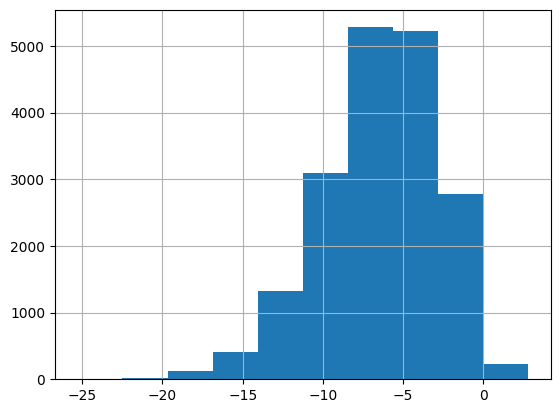

In [8]:
negative_df_results.pred_energy.hist()


In [9]:
negative_df_results.mirna_dot_bracket_5to3= negative_df_results.mirna_dot_bracket_5to3.str.replace(")", "1")

negative_df_results.mirna_dot_bracket_5to3.str.count("1").describe()

count    18501.000000
mean         7.333766
std          3.406829
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         19.000000
Name: mirna_dot_bracket_5to3, dtype: float64

<Axes: >

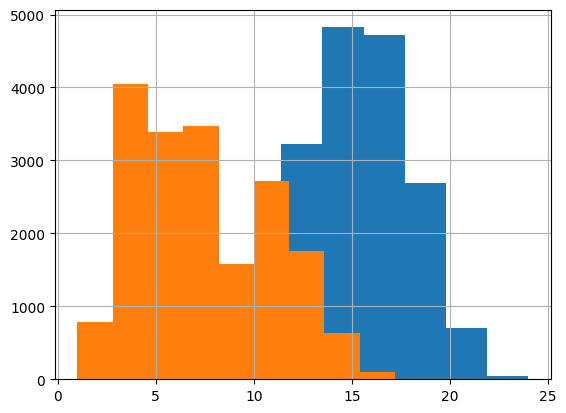

In [10]:
positive_df_results = pd.read_csv("results/rnaduplex_predictions_raw.csv")
positive_df_results.mirna_dot_bracket_5to3= positive_df_results.mirna_dot_bracket_5to3.str.replace(")", "1")

negative_df_results.mirna_dot_bracket_5to3= negative_df_results.mirna_dot_bracket_5to3.str.replace(")", "1")

positive_df_results.mirna_dot_bracket_5to3.str.count("1").hist() # blue

negative_df_results.mirna_dot_bracket_5to3.str.count("1").hist() # orange

<Axes: >

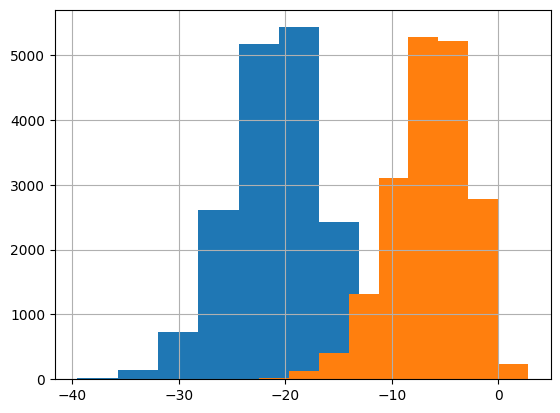

In [11]:
positive_df_results.pred_energy.hist() # blue
negative_df_results.pred_energy.hist() # orange